In [1]:
import sys, os
import lib.combined_threshold as combined_threshold
import lib.undistort_transform as undistort_transform
import glob as glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
print("Imported All Combined Libraries!")

def pipeline(img):
    with open('output_images/calibrate_camera.p', 'rb') as f:
        save_dict = pickle.load(f)
    mtx = save_dict['mtx']
    dist = save_dict['dist']

    img = cv2.undistort(img, mtx, dist, None, mtx)
    img, combined2, abs_bin, mag_bin, dir_bin, hls_s_bin, lab_b_bin, hls_l_bin = combined_threshold.combined_thresh(img)

    warped, unwarped, m, m_inv = undistort_transform.perspective_transform(img)

    return warped, unwarped, m_inv

Imposted All Combined Threshold Libraries!
Imported All Undistort Transformation Libraries!
Imported All Combined Libraries!


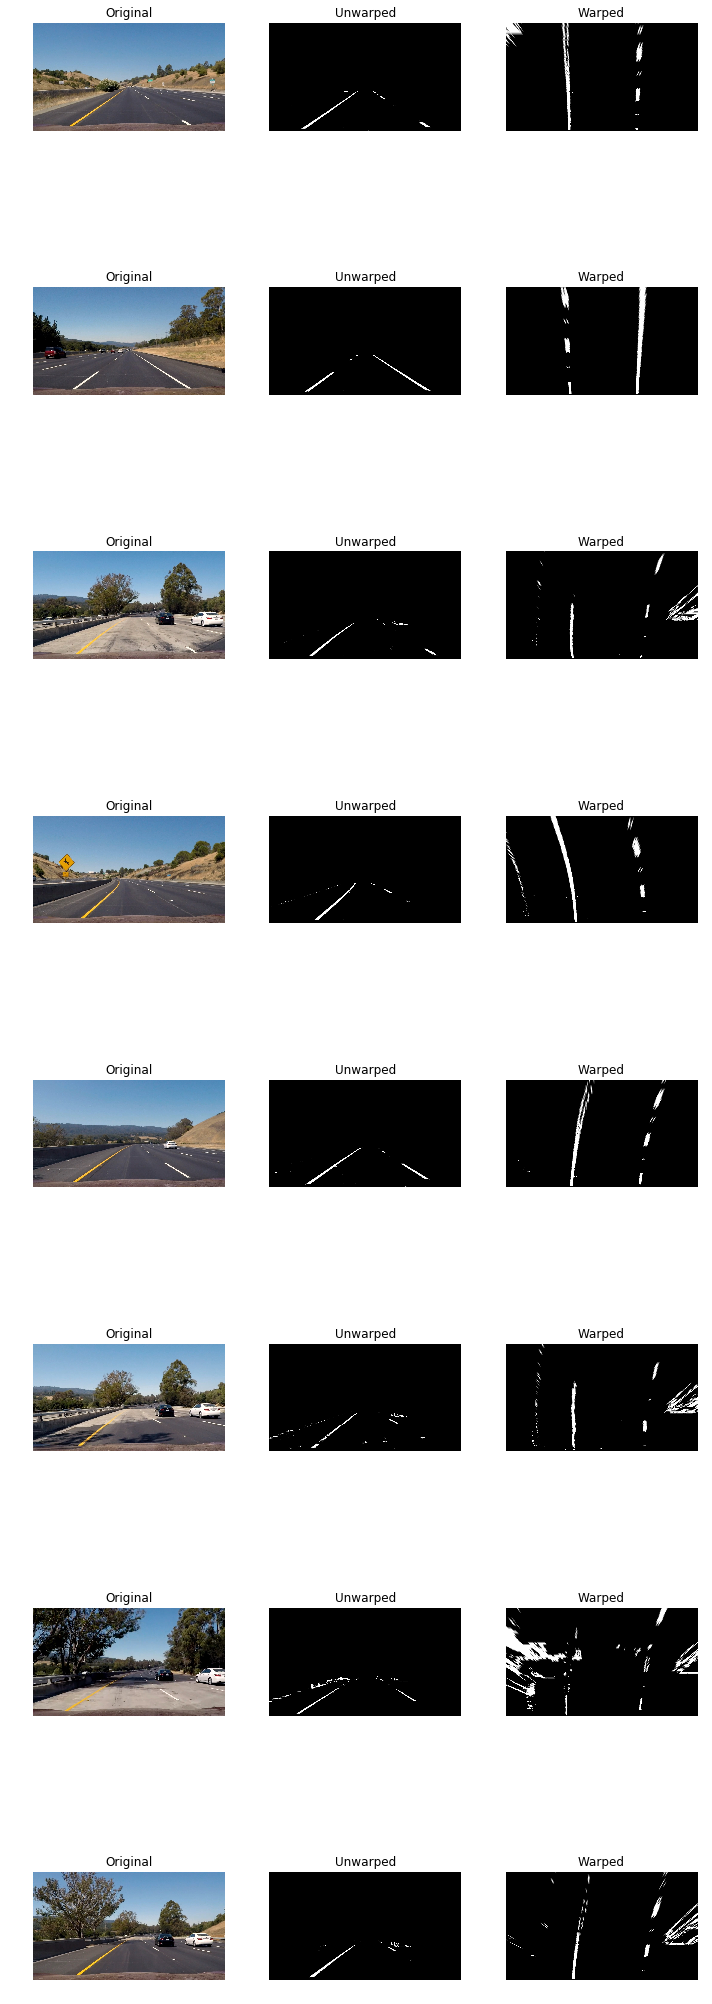

In [17]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 30))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, img_unw, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title("Original")
    i += 1
    axs[i].imshow(img_unw, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title("Unwarped")
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title("Warped")
    i += 1
plt.tight_layout()
plt.savefig('output_images/pipeline_warped.jpg')
plt.show()

In [3]:
# sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

In [19]:
def draw_sliding_box(exampleImg):
    exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
    exampleImg_bin, warped, Minv = pipeline(exampleImg)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

    h = exampleImg.shape[0]
    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    #print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

    rectangles = visualization_data[0]
    histogram = visualization_data[1]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    for rect in rectangles:
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = exampleImg_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    return left_fitx, right_fitx, histogram, out_img

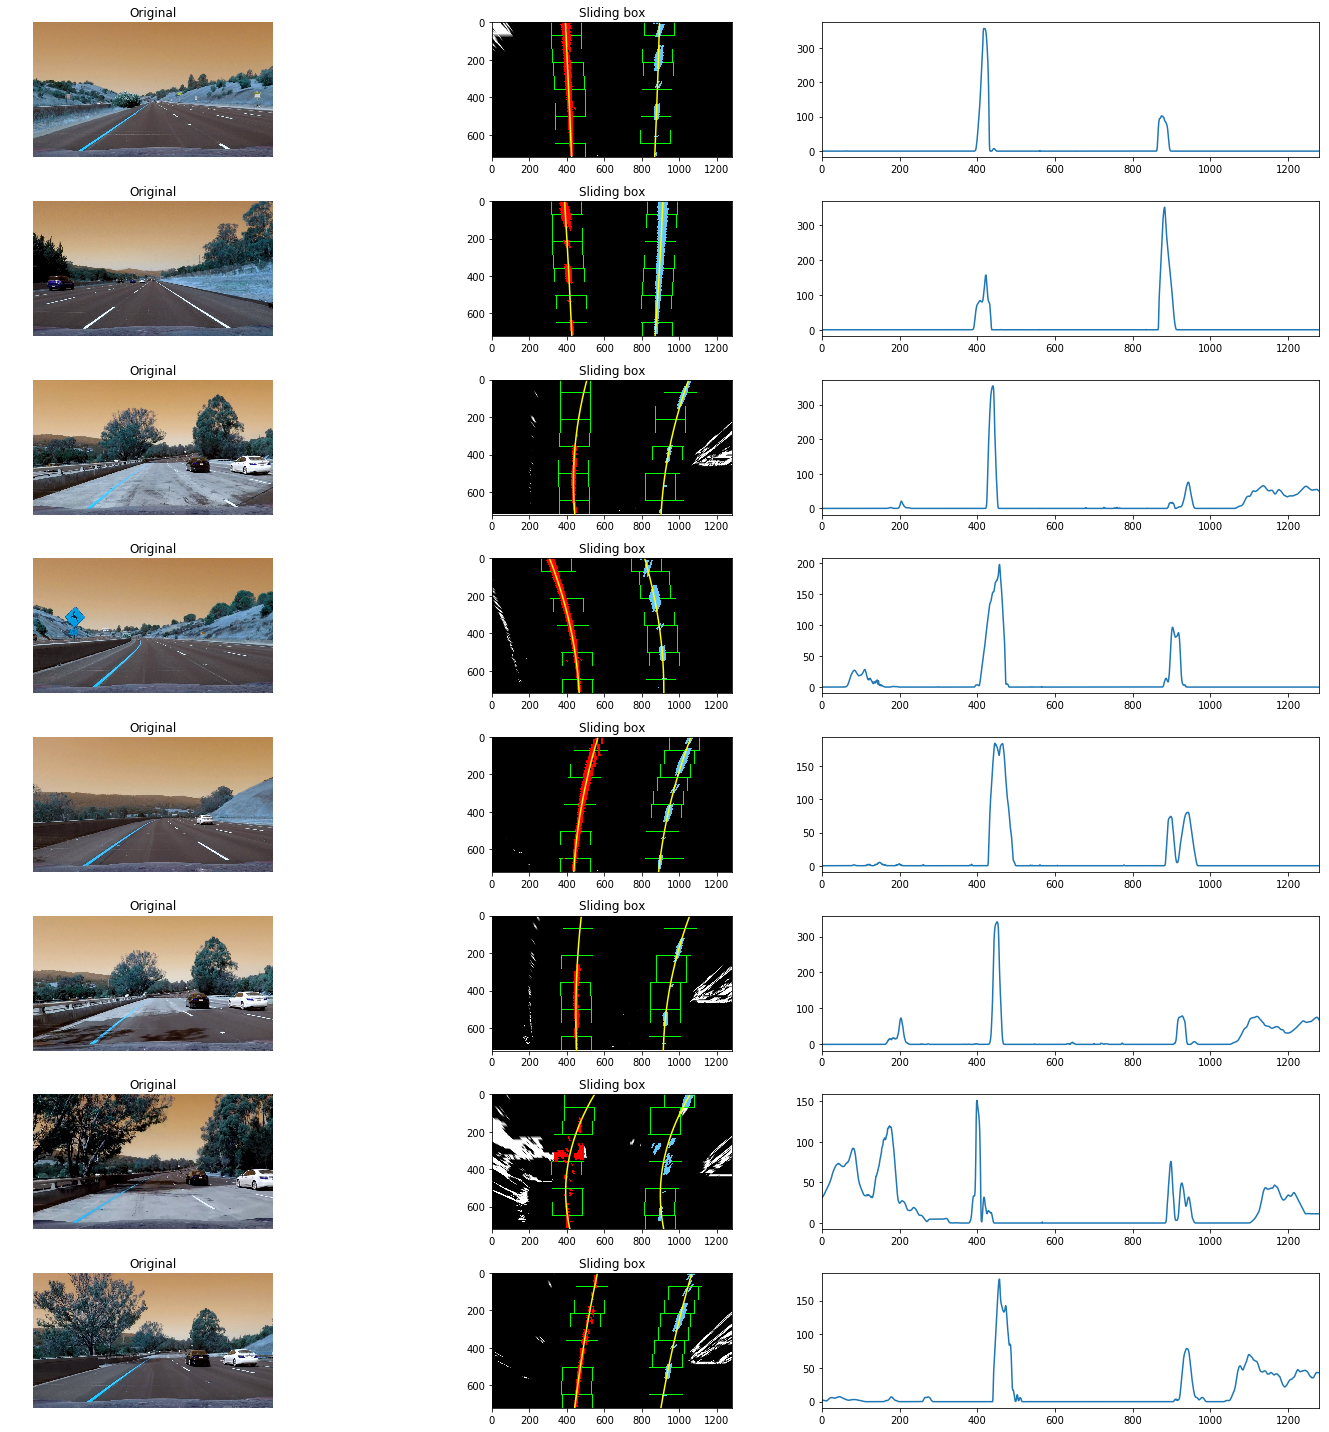

In [21]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    left_fitx, right_fitx, histogram, out_img = draw_sliding_box(img)
    
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title("Original")
    i += 1
    axs[i].imshow(out_img)
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    axs[i].set_xlim(0, 1280)
    axs[i].set_ylim(720, 0)
    axs[i].set_title("Sliding box")
    i += 1
    axs[i].plot(histogram)
    axs[i].set_xlim(0, 1280)
    i += 1
plt.tight_layout()
plt.savefig('output_images/pipeline_sliding_box.jpg')
plt.show()